In [360]:
from pathlib import Path
import pandas as pd
from settings import PROCESSED_DATA_DIR
from reduce_memory_usage import reduce_memory_usage

matches_df = pd.read_csv(Path(PROCESSED_DATA_DIR, 'bundesliga_matches.csv'))

# matches_df = reduce_memory_usage(matches_df)

In [361]:
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier


def make_predictions(data, cutoff_date='2023-04-01'):
    """
    Make predictions using the random forest classifier.

    :param data: the dataframe to use
    :param cutoff_date: the date to use for splitting the data into train and test sets
    :return: combined: a dataframe containing the actual and predicted values
    """
    # Pick the predictor columns.
    predictors = [c for c in matches_df.columns if c.startswith('feat_')]

    # Split the data into train and test sets.
    train_set = data[data['info_date'] < cutoff_date]
    test_set = data[data['info_date'] >= cutoff_date]
    print(f'Train: {len(train_set)} matches ({len(train_set) / len(data):.2%})')
    print(f'Test: {len(test_set)} matches ({len(test_set) / len(data):.2%})')

    # Create and fit (train) the model.
    model = RandomForestClassifier(
        n_estimators=50,  # number of trees in the forest
        min_samples_split=10,  # number of samples required to split an internal node
        random_state=1  # seed
    )
    model.fit(train_set[predictors], train_set['target'])

    # Make predictions on the test dataset and calculate the precision score.
    predictions = model.predict(test_set[predictors])
    precision = precision_score(test_set['target'], predictions)
    print(f'Precision: {precision:.2%}')

    # Create a dataframe containing the actual and predicted values.
    combined = pd.DataFrame(
        dict(actual=test_set['target'], prediction=predictions),
        index=test_set.index
    )
    return combined

In [362]:
combined = make_predictions(matches_df, cutoff_date='2023-10-01')

Train: 3695 matches (97.52%)
Test: 94 matches (2.48%)
Precision: 76.47%


In [363]:
def pick_confident_matches(df):
    merged = combined.merge(combined, left_on=['info_date', 'info_team'], right_on=['info_date', 'info_opponent'])
    high_confidence_matches_df = df[(merged['prediction_x'] == 1) & (df['prediction_y'] == 0)]
    precision_df = high_confidence_matches_df['actual_x'].value_counts()
    precision = precision_df.iloc[0] / (precision_df.iloc[0] + precision_df.iloc[1]) * 100
    print(f'Precision: {precision:.2f}%')
    return high_confidence_matches_df

In [364]:
combined = combined.merge(
    matches_df,
    left_index=True,
    right_index=True
)

In [365]:
combined.insert(0,'key','')
combined['key'] = combined.apply(
    lambda x: f"{x['info_date']}_{x['info_team']}_{x['info_opponent']}" if x['info_venue'] == 'Home' else f"{x['info_date']}_{x['info_opponent']}_{x['info_team']}",
    axis=1
)
combined.head()

,key,actual,prediction,feat_gf_rolling_avg,feat_ga_rolling_avg,feat_xg_rolling_avg,feat_xga_rolling_avg,feat_poss_rolling_avg,feat_attendance_rolling_avg,feat_shooting_standard_sh_rolling_avg,...,feat_opponent_code,feat_venue_code,feat_hour,feat_day_code,feat_month_code,target,info_date,info_team,info_opponent,info_venue
271,2023-10-01_Freiburg_Augsburg,0,0,1.333333,2.000000,1.466667,1.100000,41.666667,33160.000000,10.666667,...,9,0,17,6,10,0,2023-10-01,Augsburg,Freiburg,Away
272,2023-10-07_Augsburg_Darmstadt 98,0,0,0.666667,2.000000,1.100000,0.900000,44.666667,35063.333333,11.333333,...,5,1,15,5,10,0,2023-10-07,Augsburg,Darmstadt 98,Home
273,2023-10-22_Heidenheim_Augsburg,1,0,1.000000,1.666667,0.833333,1.133333,45.333333,29881.333333,12.000000,...,13,0,17,6,10,1,2023-10-22,Augsburg,Heidenheim,Away
274,2023-10-28_Augsburg_Wolfsburg,1,0,2.000000,2.000000,1.400000,1.433333,45.333333,25778.000000,13.000000,...,26,1,15,5,10,1,2023-10-28,Augsburg,Wolfsburg,Home
275,2023-11-04_Koln_Augsburg,0,0,3.000000,2.000000,1.600000,1.566667,43.000000,24066.666667,11.333333,...,16,0,15,5,11,0,2023-11-04,Augsburg,Koln,Away


In [366]:
from settings import INTERIM_DATA_DIR

odds_df = pd.read_csv(Path(INTERIM_DATA_DIR, 'bundesliga_odds.csv'))

In [367]:
odds_df.insert(0,'key','')
odds_df['key'] = odds_df.apply(
    lambda x: f"{x['date']}_{x['team']}_{x['opponent']}",
    axis=1
)
# drop date, team, opponent columns to not create duplicates when merging
odds_df.drop(columns=['date','team','opponent'], inplace=True)
odds_df.head()

,key,fthg,ftag,ftr,hthg,htag,htr,hs,as,hst,...,bbmx>2.5,bbav>2.5,bbmx<2.5,bbav<2.5,bbah,bbahh,bbmxahh,bbavahh,bbmxaha,bbavaha
0,2022-08-05_Eintracht Frankfurt_Bayern Munich,1,6,A,0,5,A,8,23,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-08-06_Augsburg_Freiburg,0,4,A,0,0,D,10,19,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-08-06_Bochum_Mainz 05,1,2,A,1,1,D,16,13,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-08-06_Monchengladbach_Hoffenheim,3,1,H,1,1,D,18,2,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-08-06_Union Berlin_Hertha BSC,3,1,H,1,0,H,18,9,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [368]:
merged_df = pd.merge(combined, odds_df, on='key', how='left')
merged_df.head()

,key,actual,prediction,feat_gf_rolling_avg,feat_ga_rolling_avg,feat_xg_rolling_avg,feat_xga_rolling_avg,feat_poss_rolling_avg,feat_attendance_rolling_avg,feat_shooting_standard_sh_rolling_avg,...,bbmx>2.5,bbav>2.5,bbmx<2.5,bbav<2.5,bbah,bbahh,bbmxahh,bbavahh,bbmxaha,bbavaha
0,2023-10-01_Freiburg_Augsburg,0,0,1.333333,2.000000,1.466667,1.100000,41.666667,33160.000000,10.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-10-07_Augsburg_Darmstadt 98,0,0,0.666667,2.000000,1.100000,0.900000,44.666667,35063.333333,11.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-10-22_Heidenheim_Augsburg,1,0,1.000000,1.666667,0.833333,1.133333,45.333333,29881.333333,12.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-10-28_Augsburg_Wolfsburg,1,0,2.000000,2.000000,1.400000,1.433333,45.333333,25778.000000,13.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-11-04_Koln_Augsburg,0,0,3.000000,2.000000,1.600000,1.566667,43.000000,24066.666667,11.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [369]:
# order by info_date
merged_df.sort_values(by='info_date', inplace=True)

In [370]:
# create a new column where b365h is multiplied by 5
# for rows where actual = 1 and prediction  = 1
# else write -5

def lam(x, bet=5):
    if x['actual'] == 1 and x['prediction'] == 1:
        if x['info_venue'] == 'Home':
            return x['b365h'] * bet - bet
        else:
            return x['b365a'] * bet - bet
    elif x['actual'] == 0 and x['prediction'] == 1:
        return -bet
    else:
        return 0

merged_df.insert(0,'profit',0)
merged_df['profit'] = merged_df.apply(
    lambda x: lam(x, 10),
    axis=1
)
merged_df.head()

,profit,key,actual,prediction,feat_gf_rolling_avg,feat_ga_rolling_avg,feat_xg_rolling_avg,feat_xga_rolling_avg,feat_poss_rolling_avg,feat_attendance_rolling_avg,...,bbmx>2.5,bbav>2.5,bbmx<2.5,bbav<2.5,bbah,bbahh,bbmxahh,bbavahh,bbmxaha,bbavaha
0,0.0,2023-10-01_Freiburg_Augsburg,0,0,1.333333,2.000000,1.466667,1.100000,41.666667,33160.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,0.0,2023-10-01_Darmstadt 98_Werder Bremen,0,0,2.666667,1.666667,2.600000,1.333333,50.333333,39305.047093,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,0.0,2023-10-01_Freiburg_Augsburg,1,0,0.666667,3.000000,0.833333,1.533333,48.333333,48266.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,0.0,2023-10-01_Darmstadt 98_Werder Bremen,1,0,1.666667,3.666667,0.600000,3.000000,35.666667,33821.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,0.0,2023-10-06_Monchengladbach_Mainz 05,0,0,2.000000,1.666667,2.533333,1.200000,50.000000,31310.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


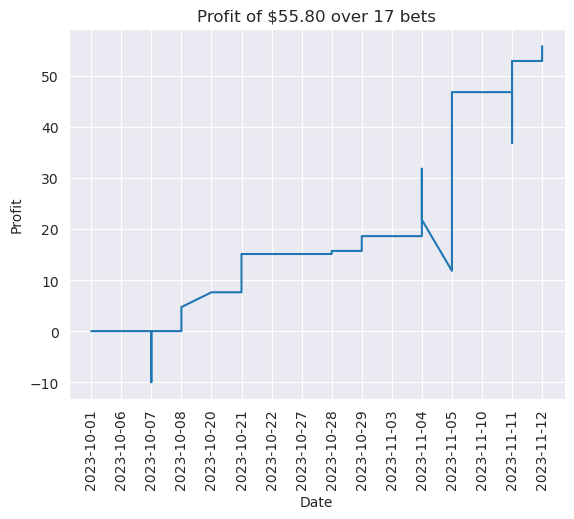

In [372]:
import matplotlib.pyplot as plt
import seaborn as sns

bets_placed = merged_df['profit'].ne(0).sum()
profit = merged_df['profit'].sum()

sns.set_style('darkgrid')
plt.plot(merged_df['info_date'], merged_df['profit'].cumsum())
plt.xticks(rotation=90)
plt.title(f'Profit of ${profit:.2f} over {bets_placed} bets')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.show()